# COMPSCI 753 Assignment 3

Chase Robertson

crob873

## Task 1: Implementation of Power Iteration Algorithm

### Implement in matrix form without teleport
- Stop criteria $||r^{(t+1)} - r^{(t)}||_1 < 0.02$
- Spider traps and dead ends not considered

In [1]:
import time
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
# convert dict mapping to sparse matrix format with 1-normalised cols
# this would not work properly with duplicate links
# confirmed no duplicate links: cat web-Google.txt | sort | uniq -c | sort | tail
def dict_to_matrix(d, n):
    row, col, data = [], [], []
    for orig, dests in d.items():
        col += [orig for d_i in dests]
        row += dests
        M_ji = 1 / len(dests)
        data += [M_ji for d_i in dests]
    
    # create sparse adjacency matrix
    return sparse.coo_matrix((data, (row, col)), (n, n))


# map space-separated id's from source to list of destinations
# assumes id's range from 0 to n by 1
def get_matrix_from_file(filename):
    file = open(filename, "r")
    paths_raw = file.readlines()
    file.close()
    
    # map from each i to j, and track max id in n
    n = 0
    path_dict = {}
    for path_raw in paths_raw:
        origin, dest = path_raw.split()
        i, j = int(origin), int(dest)
        path_dict.setdefault(i, [])
        path_dict[i].append(j)
        n = max(n, i, j)
    n += 1
    
    return dict_to_matrix(path_dict, n)
    

M = get_matrix_from_file("web-Google.txt")


In [3]:
# given col-stochastic adj matrix M, iterate until rank delta < threshold
def power_iteration(M, threshold=0.02):
    n = M.shape[0]
    
    # initialise rank and leak vectors
    r = [np.array([1/n for i in range(M.shape[0])])]
    leak = [1 - np.sum(r[-1])]

    # begin power iteration timer
    t1 = time.time()
    
    r.append(M.dot(r[-1]))
    while not np.sum(np.abs(r[-1] - r[-2])) < threshold:
        leak.append(1 - np.sum(r[-1]))
        r.append(M.dot(r[-1]))
        
    t2 = time.time()
    
    return {"r": r[-1], "r_i": r, "time": t2-t1, 
            "iter": len(r)-1, "leak": leak}

Mr = power_iteration(M, 0.02)

### Calculate rank score of each node
Report:
- Power iteration runtime
- Number of iterations
- Top 10 ranked nodes and their scores

In [4]:
def print_report(Mr):
    ranked = np.argsort(Mr["r"])[::-1]
    top10 = {x: y for x, y in zip(ranked, Mr["r"][ranked[:10]])}
    
    runtime = Mr["time"]
    iterations = Mr["iter"]
    print(f"1) Power iteration runtime: {runtime:.2f}s")
    print(f"2) Iterations needed: {iterations}")
    print(f"3) Top 10 ranked nodes:")
    for x, y in top10.items():
        print(f"\t{x}:\t{y:.7f}")

print_report(Mr)

1) Power iteration runtime: 1.73s
2) Iterations needed: 62
3) Top 10 ranked nodes:
	6116:	0.0006178
	69056:	0.0006066
	69055:	0.0006066
	69057:	0.0006066
	31563:	0.0003876
	572672:	0.0003482
	572673:	0.0003096
	60232:	0.0002711
	572674:	0.0002703
	33676:	0.0002598


## Task 2: Exploiting dead-ends
Report the leaked PageRank score in each iteration and discuss phenomenon.

In [5]:
r_0 = Mr["r_i"][0]
print(f"Initial rank vector sum:\t{np.sum(r_0)}")
r = Mr["r"]
print(f"Final rank vector sum:\t\t{np.sum(r)}")

Initial rank vector sum:	0.9999999999999983
Final rank vector sum:		0.19348414314523113


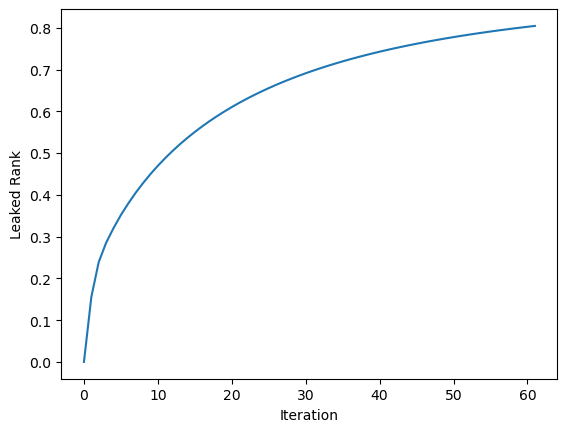

In [6]:
leaked = Mr["leak"]
plt.plot(leaked)
plt.ylabel("Leaked Rank")
plt.xlabel("Iteration")
plt.show()

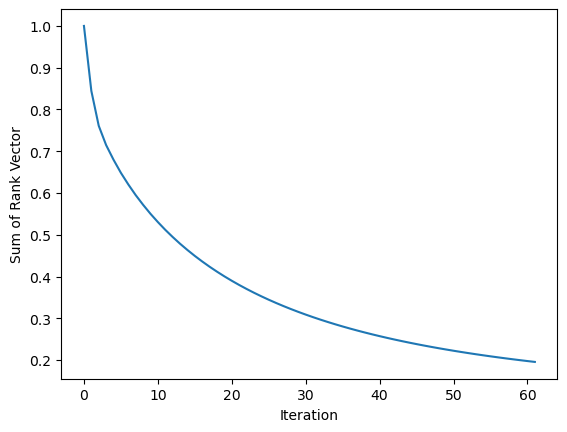

In [7]:
plt.plot(1 - np.array(leaked))
plt.ylabel("Sum of Rank Vector")
plt.xlabel("Iteration")
plt.show()

Because each node "lends" its importance to each of its out-linked nodes, nodes without out-links tend to reduce their in-linking connection's rank. The importance lent to them is not lent out to any other nodes, and not held by the dead node itself. This can be understood mathematically by noting the zero result of the dot-product operation on nodes without out-links. The ultimate effect is for total rank of all nodes to drop toward zero, which effectively raises the stopping threshold.

## Task 3: Implementation of Teleport
### Extend PageRank to handle dead ends and spider traps with teleport
- $\beta = 0.9$ by default, same stop threshold of 0.02

In [8]:
# add teleport with beta to previously defined power iteration
def power_iteration_tel(M, threshold=0.02, beta=0.9):
    n = M.shape[0]
    r = [np.array([1/n for i in range(M.shape[0])])]
    leak = [1 - np.sum(r[-1])]
    
    # define teleport proportion
    teleport = (1 - beta) / n

    t1 = time.time()
    
    # add teleport to M.r operation
    r.append(beta * M.dot(r[-1]) + teleport)
    while not np.sum(np.abs(r[-1] - r[-2])) < threshold:
        leak.append(1 - np.sum(r[-1]))
        
        # add teleport to M.r operation
        r.append(beta * M.dot(r[-1]) + teleport)
        
    t2 = time.time()
    
    return {"r": r[-1], "r_i": r, "time": t2-t1, 
            "iter": len(r)-1, "leak": leak}

Mr = power_iteration_tel(M, 0.02)


### Run power iteration with teleport
Report:
- Power iteration runtime
- Number of iterations
- Top 10 ranked nodes and their scores

In [9]:
Mr_tel = power_iteration_tel(M, 0.02, 0.9)
print_report(Mr_tel)

1) Power iteration runtime: 0.40s
2) Iterations needed: 11
3) Top 10 ranked nodes:
	2138:	0.0006792
	115:	0.0006453
	3178:	0.0006219
	2560:	0.0006128
	1950:	0.0005719
	1181:	0.0005406
	903:	0.0005179
	1611:	0.0005012
	3150:	0.0005010
	3180:	0.0004843


### Vary teleport probability
For $\beta$ in [1, 0.9, 0.8, 0.7, 0.6, 0.5], report:
- Number of iterations

In [10]:
leaks = []
betas = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
for beta in betas:
    Mr_b = power_iteration_tel(M, beta=beta)
    iterations = Mr_b["iter"]
    print(f"Beta = {beta}: {iterations} iterations")
    leaks.append(Mr_b["leak"])

Beta = 1.0: 62 iterations
Beta = 0.9: 11 iterations
Beta = 0.8: 7 iterations
Beta = 0.7: 6 iterations
Beta = 0.6: 5 iterations
Beta = 0.5: 4 iterations


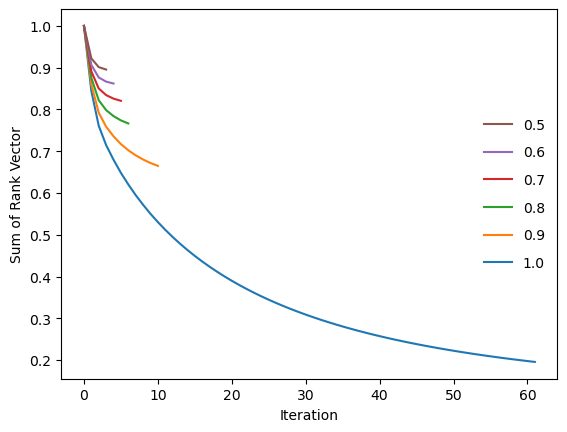

In [11]:
for leak in leaks:
    plt.plot(1 - np.array(leak))
plt.ylabel("Sum of Rank Vector")
plt.xlabel("Iteration")
plt.legend(betas, loc="right",  frameon=False, labelspacing=-3)
plt.show()

With $\beta = 1$, the result is the same as the previous experiments, because there is no teleport actually taking place. As $\beta$ takes on lower values, the number of iterations needed to reach the stopping threshold is lower. Some of the rank lent to the dead nodes is teleported back to the other nodes in the network, where it actually belongs, so the threshold is reached sooner. The overall leakage from the rank vector is reduced as $\beta$ lowers, though with very low values like 0.5, it is likely that the converged rank vector does not rank the nodes very precisely, because a significant part of each rank is shared around through teleport. Decreasing $\beta$ effectively increases the equality of the rank of each node, so less iterations are necessary to meet the convergence threshold.